In [114]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
from libpysal.weights import Queen
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle

In [115]:
pd.set_option('display.max_columns', None)

In [116]:
#Requiere openpyxl
df = pd.read_excel('../input_data/1A DELITOS DE ALTO IMPACTO.xlsx', skiprows=1)
print(df.shape)
df.head(2)

(21488, 18)


,ID,ID_CI,FECHA DE INICIO,HORA DE INICIO,CT - INICIO AP,TIPO IMPACTO,DELITO,MODALIDAD - DELITO,FECHA DE LOS HECHOS,HORA DE LOS HECHOS,CALLE 1 HECHOS,CALLE 2 HECHOS,COLONIA HECHOS,ALCALDÍA HECHOS,CT HECHOS,COORD X,COORD Y,OBSERVACIÓN
0,1,9627807,2024-01-01,09:53,COY-1,ALTO IMPACTO,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,01/01/2024,07:38,DOCTOR ANTONIO DELFIN MADRIGAL,SIN REGISTRO,PEDREGAL DE SANTO DOMINGO,COYOACAN,COY-1,-99.17231,19.321407,* LAS COORDENADAS QUE SE MUESTRAN NO CORRESPON...
1,2,9627810,2024-01-01,10:13,UAT-AZ-4,ALTO IMPACTO,HOMICIDIO DOLOSO,HOMICIDIO POR ARMA DE FUEGO,01/01/2024,05:10,ALDUCIN,ZEMPOALTECAS,TEZOZOMOC,AZCAPOTZALCO,AZ-2,-99.200193,19.493066,* LAS COORDENADAS QUE SE MUESTRAN NO CORRESPON...


In [117]:
def select_vars(df) -> pd.DataFrame:
    l_vars = ['TIPO IMPACTO','DELITO','COLONIA HECHOS','COORD X','COORD Y','HORA DE LOS HECHOS',
              'FECHA DE LOS HECHOS','ID_CI']
    
    df = df[l_vars]
    return(df)

df = select_vars(df)
print(df.shape)
df.head(2)

(21488, 8)


,TIPO IMPACTO,DELITO,COLONIA HECHOS,COORD X,COORD Y,HORA DE LOS HECHOS,FECHA DE LOS HECHOS,ID_CI
0,ALTO IMPACTO,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,PEDREGAL DE SANTO DOMINGO,-99.17231,19.321407,07:38,01/01/2024,9627807
1,ALTO IMPACTO,HOMICIDIO DOLOSO,TEZOZOMOC,-99.200193,19.493066,05:10,01/01/2024,9627810


In [118]:
def df_to_gdf(df: pd.DataFrame) -> gpd.GeoDataFrame:
    """
    Selecciona columnas específicas y convierte las coordenadas en geometría.

    Parámetros:
    df : pd.DataFrame
        El DataFrame de entrada.

    Retorna:
    gpd.GeoDataFrame
        Un GeoDataFrame con geometría creada a partir de 'COORD X' y 'COORD Y'.
    """

    # Convertir coordenadas a valores numéricos y manejar errores
    df['COORD X'] = pd.to_numeric(df['COORD X'], errors='coerce')
    df['COORD Y'] = pd.to_numeric(df['COORD Y'], errors='coerce')

    # Eliminar registros con coordenadas inválidas
    df = df.dropna(subset=['COORD X', 'COORD Y'])

    df['geometry'] = [Point(xy) for xy in zip(df['COORD X'], df['COORD Y'])]

    # Convertir a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    return gdf

gdf_puntos = df_to_gdf(df)
print(gdf_puntos.shape)
gdf_puntos.head(2)

(20191, 9)


C:\Users\Xande\AppData\Local\Temp\ipykernel_46572\362639432.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geometry'] = [Point(xy) for xy in zip(df['COORD X'], df['COORD Y'])]


,TIPO IMPACTO,DELITO,COLONIA HECHOS,COORD X,COORD Y,HORA DE LOS HECHOS,FECHA DE LOS HECHOS,ID_CI,geometry
0,ALTO IMPACTO,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,PEDREGAL DE SANTO DOMINGO,-99.172310,19.321407,07:38,01/01/2024,9627807,POINT (-99.17231 19.32141)
1,ALTO IMPACTO,HOMICIDIO DOLOSO,TEZOZOMOC,-99.200193,19.493066,05:10,01/01/2024,9627810,POINT (-99.20019 19.49307)


In [119]:
gdf_poly = gpd.read_file('../input_data/poligonos_colonias_cdmx.shp')
print(gdf_poly.shape)
gdf_poly.head()

(1543, 8)


,cve_ent,entidad,cve_alc,alc,cve_col,colonia,clasif,geometry
0,09,Ciudad de México,002,Azcapotzalco,002-001,Aguilera,Colonia,"POLYGON ((-99.15913 19.47261, -99.15906 19.473..."
1,09,Ciudad de México,002,Azcapotzalco,002-002,Aldana,Colonia,"POLYGON ((-99.15171 19.46819, -99.15157 19.469..."
2,09,Ciudad de México,002,Azcapotzalco,002-003,Ampliacion Cosmopolita,Colonia,"POLYGON ((-99.16362 19.47223, -99.16334 19.472..."
3,09,Ciudad de México,002,Azcapotzalco,002-004,Ampliacion Del Gas,Colonia,"POLYGON ((-99.16152 19.46774, -99.16152 19.468..."
4,09,Ciudad de México,002,Azcapotzalco,002-005,Ampliacion Petrolera,Colonia,"POLYGON ((-99.19762 19.48231, -99.19649 19.485..."


In [120]:
gdf_puntos['DELITO'].value_counts()

DELITO
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA       7303
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                       5745
VIOLACIÓN                                                  1938
ROBO A NEGOCIO CON VIOLENCIA                               1695
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA       912
HOMICIDIO DOLOSO                                            765
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                       642
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO               353
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA     350
ROBO A CASA HABITACIÓN CON VIOLENCIA                        208
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA               133
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA     127
ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA                     13
SECUESTRO                                                     7
Name: count, dtype: int64

In [121]:
def count_crimes_by_polygon(points_gdf, polygons_gdf):
    """
    Counts the number of crimes of type 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA'
    within each polygon.

    Args:
        points_gdf (gpd.GeoDataFrame): GeoDataFrame containing point geometries and crime data.
        polygons_gdf (gpd.GeoDataFrame): GeoDataFrame containing polygon geometries.

    Returns:
        gpd.GeoDataFrame: Polygons GeoDataFrame with an additional column 'crime_count'
        indicating the number of matching crimes within each polygon.
    """
    # Filter points by crime type
    crime_type = 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA'
    filtered_points = points_gdf[points_gdf['DELITO'] == crime_type]

    # Perform spatial join to find points within polygons
    joined = gpd.sjoin(filtered_points, polygons_gdf, predicate='within')

    # Count crimes per polygon
    crimen_counts = joined.groupby('index_right').size()

    # Merge counts back to polygons
    polygons_gdf['crimen_count'] = polygons_gdf.index.map(crimen_counts).fillna(0).astype(int)

    return polygons_gdf

gdf_join = count_crimes_by_polygon(gdf_puntos, gdf_poly)
print(gdf_join.shape)
gdf_join.tail(2)

(1543, 9)


,cve_ent,entidad,cve_alc,alc,cve_col,colonia,clasif,geometry,crimen_count
1541,09,Ciudad de México,017,Venustiano Carranza,017-066,Venustiano Carranza,Colonia,"POLYGON ((-99.11429 19.43788, -99.11425 19.438...",3
1542,09,Ciudad de México,017,Venustiano Carranza,017-067,Zona Centro,Colonia,"POLYGON ((-99.12606 19.42288, -99.12606 19.422...",92


In [122]:
def find_optimal_clusters(X, max_clusters=10):
    """
    Determines the optimal number of clusters using the silhouette score.

    Args:
        X (array-like): Data to cluster.
        max_clusters (int): Maximum number of clusters to test.

    Returns:
        int: Optimal number of clusters.
    """
    best_score = -1
    best_k = 2
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

def find_optimal_clusters_elbow(X, max_clusters=10):
    """
    Determines the optimal number of clusters using the elbow method.

    Args:
        X (array-like): Data to cluster.
        max_clusters (int): Maximum number of clusters to test.

    Returns:
        int: Optimal number of clusters.
    """
    distortions = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    # Find the 'elbow'
    diffs = np.diff(distortions)
    elbow = np.argmin(diffs) + 1

    return elbow

In [133]:

def cluster_polygons(polygons_gdf, max_clusters=10):
    """
    Clusters polygons using KMeans and Agglomerative Clustering with optimal clusters.

    Args:
        polygons_gdf (gpd.GeoDataFrame): GeoDataFrame with 'crime_count'.
        max_clusters (int): Maximum number of clusters to test for optimal selection.

    Returns:
        gpd.GeoDataFrame: Polygons GeoDataFrame with cluster labels.
    """
    # Prepare data for clustering
    X = polygons_gdf[['crimen_count']]

    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Find optimal clusters for KMeans
    optimal_kmeans_clusters = find_optimal_clusters_elbow(X_scaled, max_clusters)
    kmeans = KMeans(n_clusters=7, random_state=42)
    polygons_gdf['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

    # Create connectivity matrix using Queen adjacency (W)
    w = Queen.from_dataframe(polygons_gdf)
    connectivity = w.sparse

    # Find optimal clusters for Agglomerative Clustering
    optimal_agg_clusters = find_optimal_clusters_elbow(X_scaled, max_clusters)
    agg_clustering = AgglomerativeClustering(n_clusters=7, connectivity=connectivity)
    polygons_gdf['agg_cluster'] = agg_clustering.fit_predict(X_scaled)

    # Save models and data
    with open('../models/kmeans_model.pkl', 'wb') as f:
        pickle.dump(kmeans, f)

    with open('../models/agg_clustering_model.pkl', 'wb') as f:
        pickle.dump(agg_clustering, f)

    with open('../models/standarizer.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    #polygons_gdf.to_pickle('../output_data/polygons_gdf.pkl')
    # Guardar GeoDataFrame como shapefile
    polygons_gdf.to_file('../output_data/polygons_gdf.geojson')
    
    return polygons_gdf

In [134]:
gdf_join = cluster_polygons(gdf_join, max_clusters=7)
print(gdf_join.shape)
gdf_join.head(2)

c:\Users\Xande\anaconda3\envs\geo_unam1\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\Xande\anaconda3\envs\geo_unam1\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\Xande\anaconda3\envs\geo_unam1\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\Xande\anaconda3\envs\geo_unam1\lib\site-packages\sklearn\cluster\_kmeans.py:1429: 

(1543, 11)


,cve_ent,entidad,cve_alc,alc,cve_col,colonia,clasif,geometry,crimen_count,kmeans_cluster,agg_cluster
0,09,Ciudad de México,002,Azcapotzalco,002-001,Aguilera,Colonia,"POLYGON ((-99.15913 19.47261, -99.15906 19.473...",0,0,0
1,09,Ciudad de México,002,Azcapotzalco,002-002,Aldana,Colonia,"POLYGON ((-99.15171 19.46819, -99.15157 19.469...",0,0,0


In [125]:
gdf_join['crimen_count'].value_counts()

crimen_count
0      416
1      276
2      171
3      140
4      108
5       82
6       44
7       44
8       43
9       32
11      23
10      23
12      17
13      15
16      10
18      10
14       9
22       8
17       8
15       8
20       6
26       5
23       4
28       4
19       3
21       3
30       2
39       2
82       2
24       2
35       2
32       1
33       1
51       1
45       1
50       1
56       1
25       1
81       1
31       1
57       1
46       1
432      1
48       1
43       1
27       1
29       1
76       1
40       1
60       1
34       1
92       1
Name: count, dtype: int64

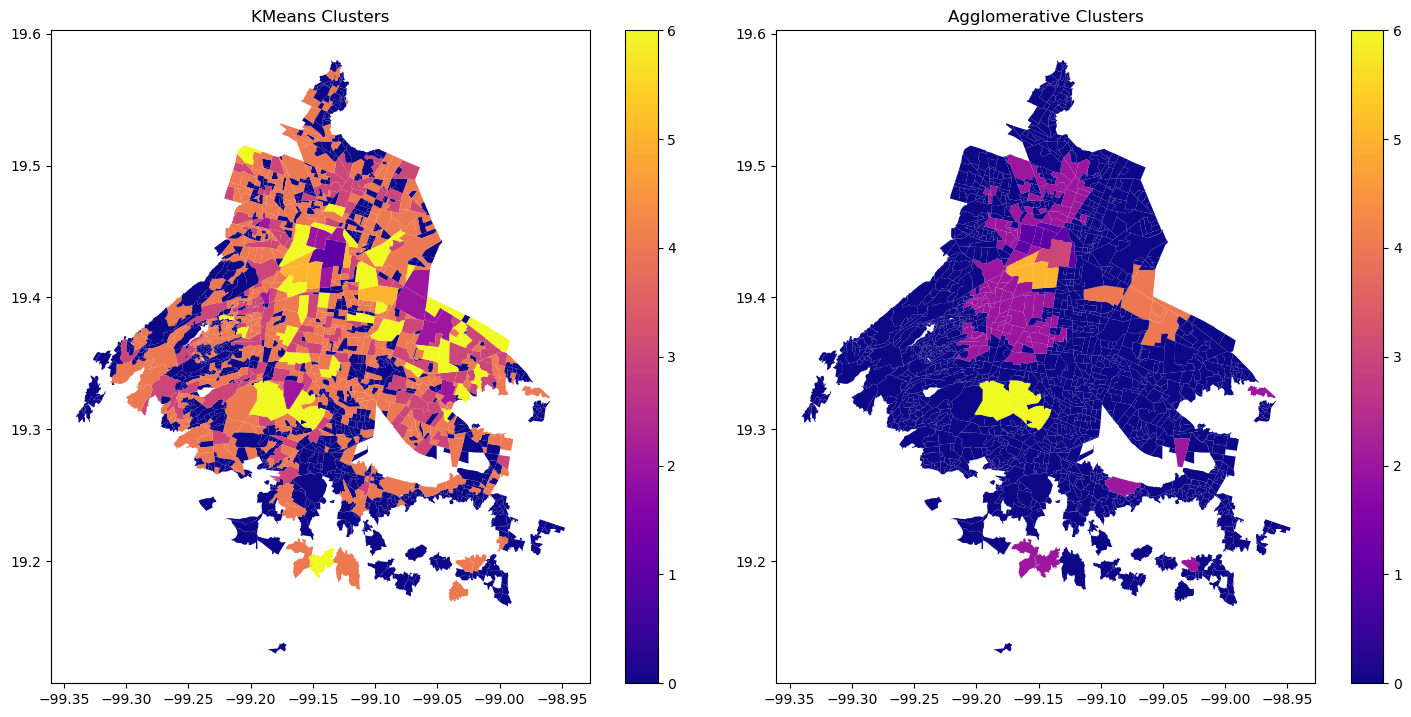

In [126]:
def plot_clusters(polygons_gdf):
    """
    Generates maps showing clusters for KMeans and Agglomerative Clustering.

    Args:
        polygons_gdf (gpd.GeoDataFrame): GeoDataFrame containing clustering results.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Plot KMeans Clusters
    polygons_gdf.plot(column='kmeans_cluster', cmap='plasma', legend=True, ax=axes[0])
    axes[0].set_title('KMeans Clusters')

    # Plot Agglomerative Clusters
    polygons_gdf.plot(column='agg_cluster', cmap='plasma', legend=True, ax=axes[1])
    axes[1].set_title('Agglomerative Clusters')

    plt.tight_layout()
    plt.show()

plot_clusters(gdf_join)

In [127]:
gdf_join.head(2)

,cve_ent,entidad,cve_alc,alc,cve_col,colonia,clasif,geometry,crimen_count,kmeans_cluster,agg_cluster
0,09,Ciudad de México,002,Azcapotzalco,002-001,Aguilera,Colonia,"POLYGON ((-99.15913 19.47261, -99.15906 19.473...",0,0,0
1,09,Ciudad de México,002,Azcapotzalco,002-002,Aldana,Colonia,"POLYGON ((-99.15171 19.46819, -99.15157 19.469...",0,0,0


In [128]:
gdf_join['agg_cluster'].agg({'crimen_count':'count'})

crimen_count    1543
Name: agg_cluster, dtype: int64

In [129]:
def summarize_clusters(polygons_gdf):
    """
    Provides a summary of crime_count statistics for each cluster in Agglomerative Clustering.

    Args:
        polygons_gdf (gpd.GeoDataFrame): GeoDataFrame containing clustering results.

    Returns:
        pd.DataFrame: Summary statistics for each cluster.
    """
    summary = polygons_gdf.groupby('agg_cluster')['crimen_count'].describe()
    return summary

summarize_clusters(gdf_join)

,count,mean,std,min,25%,50%,75%,max
agg_cluster,,,,,,,,
0,1406.0,3.112376,4.392832,0.0,0.0,2.0,4.00,39.0
1,7.0,48.000000,22.300972,28.0,31.0,48.0,53.00,92.0
2,112.0,11.714286,8.950745,0.0,7.0,9.0,16.00,57.0
3,1.0,432.000000,NaN,432.0,432.0,432.0,432.00,432.0
4,8.0,40.000000,16.860774,24.0,26.0,39.5,43.75,76.0
5,4.0,72.500000,18.339393,45.0,72.0,81.5,82.00,82.0
6,5.0,36.000000,14.335271,24.0,26.0,35.0,35.00,60.0


In [135]:
import os
#polygons_gdf = gpd.read_file((os.path.join('output_data','polygons_gdf.shp')))
polygons_gdf = gpd.read_file('../output_data/polygons_gdf.geojson')
polygons_gdf.head(2)

,cve_ent,entidad,cve_alc,alc,cve_col,colonia,clasif,crimen_count,kmeans_cluster,agg_cluster,geometry
0,09,Ciudad de México,002,Azcapotzalco,002-001,Aguilera,Colonia,0,0,0,"POLYGON ((-99.15913 19.47261, -99.15906 19.473..."
1,09,Ciudad de México,002,Azcapotzalco,002-002,Aldana,Colonia,0,0,0,"POLYGON ((-99.15171 19.46819, -99.15157 19.469..."
